# Project - Orbits



In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
from collections import Counter
from sklearn import preprocessing
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from matplotlib import pyplot as plt 
from imblearn.over_sampling import SMOTE 
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_fscore_support

from matplotlib import pyplot
from sklearn.linear_model import LogisticRegression
#from imblearn import under_sampling, over_sampling

##nn!

from sklearn.neural_network import MLPClassifier
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.pipeline import make_pipeline


## Loading the dataset

In [2]:
# Read in the dataset
pd.set_option('display.max_columns', 50)
df = pd.read_csv('shortenedorbit.csv', low_memory=False)
#df = df.drop(columns=df.columns[0], axis=1)
df = df.drop(['Name', 'Arc_years', 'Number','Computer', 'Last_obs', 'Principal_desig',
              'Other_desigs','Ref', 'Hex_flags', 'U'],axis='columns')

df['Perturbers'] = df['Perturbers'].fillna('No_Coarse')
df['Perturbers_2'] = df['Perturbers_2'].fillna('No_Precise')
df = df.drop(df[df['Orbit_type'] == 'MBA'].sample(frac=.50).index)
possibleLabels = df.Orbit_type.value_counts()

labeldummies = pd.get_dummies(df.Orbit_type)
pert1dummies = pd.get_dummies(df.Perturbers)
pert2dummies = pd.get_dummies(df.Perturbers_2)
df = pd.concat([pert1dummies,pert2dummies,df],axis='columns')
#df = df.drop(['Orbit_type'],axis='columns')
df = df.drop(['Perturbers'],axis='columns')
df = df.drop(['Perturbers_2'],axis='columns')
df = df.fillna(0)
df.head()

,M-h,M-v,No_Coarse,38h,3Eh,3Ek,No_Precise,NEO_flag,One_km_NEO_flag,PHA_flag,H,G,Num_obs,rms,Epoch,M,Peri,Node,i,e,n,a,Num_opps,Tp,Orbital_period,Perihelion_dist,Aphelion_dist,Semilatus_rectum,Synodic_period,Orbit_type
1,0,1,0,1,0,0,0,0.0,0.0,0.0,16.0,0.15,144.0,0.33,2459200.5,334.72919,35.72789,302.53648,8.37753,0.119916,0.229829,2.639571,9,2.459310e+06,4.288446,2.323043,2.956098,1.300807,1.304095,MBA
2,0,1,0,1,0,0,0,0.0,0.0,0.0,16.8,0.15,171.0,0.32,2459200.5,14.03074,202.06597,152.13493,14.20004,0.221219,0.215091,2.758806,10,2.459135e+06,4.582282,2.148507,3.369106,1.311898,1.279152,MBA
3,0,1,0,1,0,0,0,0.0,0.0,0.0,17.0,0.15,116.0,0.25,2459200.5,226.30053,147.59857,170.66127,13.29714,0.059035,0.220231,2.715714,11,2.459808e+06,4.475341,2.555393,2.876036,1.353125,1.287742,MBA
4,0,1,0,1,0,0,0,0.0,0.0,0.0,17.8,0.15,156.0,0.30,2459200.5,10.21045,269.35576,100.74790,3.18772,0.219200,0.271569,2.361652,6,2.459163e+06,3.629309,1.843977,2.879327,1.124089,1.380328,MBA
6,0,1,0,1,0,0,0,0.0,0.0,0.0,16.4,0.15,48.0,0.32,2459200.5,59.12060,216.97141,239.56374,11.93388,0.195066,0.179229,3.115522,6,2.458871e+06,5.499160,2.507791,3.723254,1.498487,1.222264,MBA


All possible orbit classifications

In [3]:
possibleLabels

MBA                                           1127
Hungaria                                        54
Object with perihelion distance < 1.665 AU      53
Apollo                                          34
Jupiter Trojan                                  26
Amor                                            24
Phocaea                                         19
Hilda                                           19
Aten                                            10
Distant Object                                   8
Name: Orbit_type, dtype: int64

All features of our dataset (excl. orbit type)

In [4]:
df.dtypes
df.columns

Index(['M-h', 'M-v', 'No_Coarse', '38h', '3Eh', '3Ek', 'No_Precise',
       'NEO_flag', 'One_km_NEO_flag', 'PHA_flag', 'H', 'G', 'Num_obs', 'rms',
       'Epoch', 'M', 'Peri', 'Node', 'i', 'e', 'n', 'a', 'Num_opps', 'Tp',
       'Orbital_period', 'Perihelion_dist', 'Aphelion_dist',
       'Semilatus_rectum', 'Synodic_period', 'Orbit_type'],
      dtype='object')

## Preprocessing

Splitting the data, scaling the data, and label encoding

In [5]:
le = preprocessing.LabelEncoder()
y_cm = np.unique(df['Orbit_type'])
y = df['Orbit_type']
y = le.fit_transform(y)

np.unique(y)
df = df.drop(['Orbit_type'], axis = 'columns')



In [6]:
X = df.iloc[:,:40]
X_scaled = preprocessing.scale(X)



X_train, X_test, y_train, y_test = train_test_split(X_scaled,y, random_state=42)

smt = SMOTE(k_neighbors=3)
X_train_smt, y_train_smt = smt.fit_resample(X_train, y_train)
print("Shapes of data")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)
print("X_train_smt:", X_train_smt.shape)
print("y_train_smt:", y_train_smt.shape)
print("y_test:",Counter(y_test))
print("y_train",Counter(y_train_smt))

Shapes of data
X_train: (1030, 29)
y_train: (1030,)
X_test: (344, 29)
y_test: (344,)
X_train_smt: (8510, 29)
y_train_smt: (8510,)
y_test: Counter({7: 276, 8: 21, 5: 18, 6: 7, 0: 7, 1: 5, 2: 4, 9: 3, 3: 2, 4: 1})
y_train Counter({7: 851, 4: 851, 6: 851, 8: 851, 9: 851, 0: 851, 5: 851, 1: 851, 2: 851, 3: 851})


## NEURAL NETWORK

In [7]:
mlp = MLPClassifier(hidden_layer_sizes=(100,), activation='logistic', solver='adam', max_iter=5000)
mlp.fit(X_train,y_train)
predict_train = mlp.predict(X_train)
predict_test = mlp.predict(X_test)
mlp.score(X_train, y_train)
print(confusion_matrix(y_train,predict_train))
print(classification_report(y_train,predict_train))

[[ 17   0   0   0   0   0   0   0   0   0]
 [  0  29   0   0   0   0   0   0   0   0]
 [  0   0   6   0   0   0   0   0   0   0]
 [  0   0   0   6   0   0   0   0   0   0]
 [  0   0   0   0  18   0   0   0   0   0]
 [  0   0   0   0   0  36   0   0   0   0]
 [  0   0   0   0   0   0  19   0   0   0]
 [  0   0   0   0   1   0   0 850   0   0]
 [  0   0   0   0   0   0   0   0  32   0]
 [  0   0   0   0   0   0   0   2   0  14]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        29
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00         6
           4       0.95      1.00      0.97        18
           5       1.00      1.00      1.00        36
           6       1.00      1.00      1.00        19
           7       1.00      1.00      1.00       851
           8       1.00      1.00      1.00        32
           9       1.00     

In [8]:
epochs = range(1,50)
kf = KFold(n_splits=10)
mlp_logistic_training_acc = []
mlp_logistic_test_acc = []

mlp_relu_training_acc = []
mlp_relu_test_acc = []

mlp_tanh_training_acc = []
mlp_tanh_test_acc = []

In [9]:

def neuralNetwork_alphaLoop(epochs):
    mlp_logistic = MLPClassifier(max_iter=epochs,hidden_layer_sizes=(50,), activation='logistic', solver='adam')
    mlp_relu = MLPClassifier(max_iter=epochs,hidden_layer_sizes=(50,), activation='relu', solver='adam')
    mlp_tanh = MLPClassifier(max_iter=epochs,hidden_layer_sizes=(50,), activation='tanh', solver='adam')
    
    train_mlp_logistic = []
    train_mlp_relu = []
    train_mlp_tanh = []

    test_mlp_logistic = []
    test_mlp_relu = []
    test_mlp_tanh = [] 
    
    for train, test in kf.split(X_train):
        X_tr = X_train[train,:]
        y_tr = y_train[train]
        X_ts = X_train[test,:]
        y_ts = y_train[test]
        
        X_tr = preprocessing.scale(X_tr)
        X_ts = preprocessing.scale(X_ts)
        
        sm = SMOTE(k_neighbors=3)
        X_tr_smt, y_tr_smt = sm.fit_resample(X_tr, y_tr)
        
        mlp_logistic.fit(X_tr_smt,y_tr_smt)
        train_mlp_logistic_yhat_train = mlp_logistic.predict(X_tr_smt)
        train_mlp_logistic_yhat_test = mlp_logistic.predict(X_ts)
        train_mlp_logistic.append(metrics.accuracy_score(y_tr_smt, train_mlp_logistic_yhat_train))
        test_mlp_logistic.append(metrics.accuracy_score(y_ts, train_mlp_logistic_yhat_test))
        
        
        
        mlp_relu.fit(X_tr_smt,y_tr_smt)
        mlp_relu_yhat_train = mlp_relu.predict(X_tr_smt)
        mlp_relu_yhat_test = mlp_relu.predict(X_ts)
        train_mlp_relu.append(metrics.accuracy_score(y_tr_smt, mlp_relu_yhat_train))
        test_mlp_relu.append(metrics.accuracy_score(y_ts, mlp_relu_yhat_test))
        
        
        mlp_tanh.fit(X_tr_smt,y_tr_smt)
        mlp_tanh_yhat_train = mlp_tanh.predict(X_tr_smt)
        mlp_tanh_yhat_test = mlp_tanh.predict(X_ts)
        train_mlp_tanh.append(metrics.accuracy_score(y_tr_smt, mlp_tanh_yhat_train))
        test_mlp_tanh.append(metrics.accuracy_score(y_ts, mlp_tanh_yhat_test))
        
    
    print("hi")
    mlp_logistic_training_acc.append(np.mean(train_mlp_logistic))
    mlp_logistic_test_acc.append(np.mean(test_mlp_logistic))
    
    mlp_relu_training_acc.append(np.mean(train_mlp_relu))
    mlp_relu_test_acc.append(np.mean(test_mlp_relu))

    mlp_tanh_training_acc.append(np.mean(train_mlp_tanh))
    mlp_tanh_test_acc.append(np.mean(test_mlp_tanh))

        




In [10]:
for c in epochs:
    print(c)
    neuralNetwork_alphaLoop(c)

1


C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston

C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston

hi
2


C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Alston

C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston

hi
3


C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston

C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Alston

hi
4


C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Alston

C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston

hi
5


C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Alston

C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston

hi
6


C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Alston

C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston

hi
7


C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (7) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (7) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (7) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Alston

C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (7) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (7) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (7) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston

hi
8


C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (8) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (8) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (8) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Alston

C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (8) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (8) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (8) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston

hi
9


C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (9) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (9) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (9) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Alston

C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (9) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (9) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (9) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston

hi
10


C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

hi
11


C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (11) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (11) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (11) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (11) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (11) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (11) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

hi
12


C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (12) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (12) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (12) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (12) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (12) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (12) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

hi
13


C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (13) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (13) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (13) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (13) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (13) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (13) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

hi
14


C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (14) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (14) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (14) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (14) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (14) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (14) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

hi
15


C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (15) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (15) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (15) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (15) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (15) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (15) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

hi
16


C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (16) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (16) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (16) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (16) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (16) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (16) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

hi
17


C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (17) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (17) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (17) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (17) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (17) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (17) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

hi
18


C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (18) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (18) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (18) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (18) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (18) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (18) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

hi
19


C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (19) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (19) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (19) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (19) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (19) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (19) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

hi
20


C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

hi
21


C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (21) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (21) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (21) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (21) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (21) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (21) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

hi
22


C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (22) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (22) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (22) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (22) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (22) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (22) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

hi
23


C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (23) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (23) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (23) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (23) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (23) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (23) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

hi
24


C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (24) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (24) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (24) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (24) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (24) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (24) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

hi
25


C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

hi
26


C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (26) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (26) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (26) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (26) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (26) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (26) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

hi
27


C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (27) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (27) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (27) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (27) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (27) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (27) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

hi
28


C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (28) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (28) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (28) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (28) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (28) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (28) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

hi
29


C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (29) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (29) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (29) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (29) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (29) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (29) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

hi
30


C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

hi
31


C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (31) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (31) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (31) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (31) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (31) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (31) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

hi
32


C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (32) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (32) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (32) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (32) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (32) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (32) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

hi
33


C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (33) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (33) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (33) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (33) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (33) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (33) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

hi
34


C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (34) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (34) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (34) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (34) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (34) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (34) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

hi
35


C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (35) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (35) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (35) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (35) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (35) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (35) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

hi
36


C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (36) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (36) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (36) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (36) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (36) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (36) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

hi
37


C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (37) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (37) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (37) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (37) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (37) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (37) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

hi
38


C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (38) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (38) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (38) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (38) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (38) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (38) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

hi
39


C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (39) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (39) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (39) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (39) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (39) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (39) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

hi
40


C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

hi
41


C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (41) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (41) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (41) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (41) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (41) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (41) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

hi
42


C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (42) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (42) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (42) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (42) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (42) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (42) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

hi
43


C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (43) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (43) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (43) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (43) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (43) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (43) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

hi
44


C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (44) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (44) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (44) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (44) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (44) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (44) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

hi
45


C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (45) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (45) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (45) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (45) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (45) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (45) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

hi
46


C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (46) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (46) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (46) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (46) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (46) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (46) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

hi
47


C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (47) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (47) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (47) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (47) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (47) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (47) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

hi
48


C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (48) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (48) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (48) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (48) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (48) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (48) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

hi
49


C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (49) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (49) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (49) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (49) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (49) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (49) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Alston\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Als

hi


C:\Users\Alston\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (49) reached and the optimization hasn't converged yet.
  warnings.warn(


## Printing Neural Network Accuracy Graphs

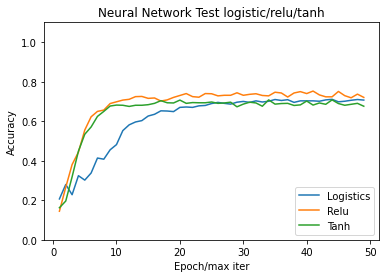

In [11]:
plt.title("Neural Network Test logistic/relu/tanh") 
plt.xlabel("Epoch/max iter") 
plt.ylabel("Accuracy") 
plt.yscale('linear')
plt.xscale('linear')
plt.plot(epochs,mlp_logistic_test_acc) 
plt.plot(epochs,mlp_relu_test_acc) 
plt.plot(epochs,mlp_tanh_test_acc) 
plt.legend(['Logistics', 'Relu', 'Tanh'], loc='lower right')
plt.gca().set_ylim([0, 1.1])
plt.savefig('Neural Network Test Accuracy.png')
plt.show()

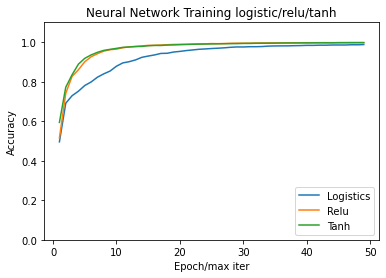

In [12]:
plt.title("Neural Network Training logistic/relu/tanh") 
plt.xlabel("Epoch/max iter") 
plt.ylabel("Accuracy") 
plt.yscale('linear')
plt.xscale('linear')
plt.plot(epochs,mlp_logistic_training_acc) 
plt.plot(epochs,mlp_relu_training_acc) 
plt.plot(epochs,mlp_tanh_training_acc) 
plt.legend(['Logistics', 'Relu', 'Tanh'], loc='lower right')
plt.gca().set_ylim([0, 1.1])
plt.savefig('Neural Network Training Accuracy.png')
plt.show()

In [13]:
for idx, x in enumerate(mlp_logistic_training_acc):
    print("current epochs: ",epochs[idx])
    print(mlp_logistic_test_acc[idx])
    print(mlp_relu_test_acc[idx])
    print(mlp_tanh_test_acc[idx])

current epochs:  1
0.20679611650485435
0.14466019417475728
0.16213592233009705
current epochs:  2
0.2796116504854369
0.2660194174757281
0.1961165048543689
current epochs:  3
0.22815533980582522
0.38058252427184464
0.3184466019417475
current epochs:  4
0.32427184466019415
0.4436893203883495
0.44854368932038835
current epochs:  5
0.3019417475728155
0.5553398058252427
0.5339805825242718
current epochs:  6
0.3378640776699029
0.6223300970873786
0.5708737864077669
current epochs:  7
0.4135922330097087
0.649514563106796
0.6242718446601943
current epochs:  8
0.4077669902912621
0.6563106796116505
0.649514563106796
current epochs:  9
0.45533980582524275
0.6893203883495145
0.6766990291262135
current epochs:  10
0.48155339805825237
0.6980582524271843
0.6815533980582524
current epochs:  11
0.5524271844660193
0.7067961165048543
0.6805825242718446
current epochs:  12
0.5815533980582523
0.7106796116504854
0.674757281553398
current epochs:  13
0.596116504854369
0.7242718446601941
0.6805825242718446
cur